In [1]:
import time
from selenium import webdriver 
from selenium.webdriver.common.keys import Keys
import pandas as pd
import seaborn as sns
import datetime
import json
import pymongo
from pymongo import MongoClient

In [ ]:
browser = webdriver.Chrome('D:\ipssi\webscrapping\chromedriver.exe')

In [ ]:
browser.get('https://www.matchendirect.fr/equipe/paris-saint-germain.html')
time.sleep(3)

In [ ]:
browser.maximize_window()
time.sleep(2)

In [ ]:
test = browser.find_elements_by_css_selector('#livescore > div:nth-child(1) .panel-body table.table-hover td.lm3 span.lm3_score.n, #livescore > div:nth-child(1) .panel-body table.table-hover td.lm3 span.lm3_score.g, #livescore > div:nth-child(1) .panel-body table.table-hover td.lm3 span.lm3_score.p')
list_elem = []
def hasNumbers(inputString):
        return any(char.isdigit() for char in inputString)
for i in test:

    lol = i.find_element_by_xpath('..')
    list_elem.append(lol.get_attribute('href'))
    
dict_test = []
for url in list_elem :
    browser.get(url)
    title = browser.find_element_by_tag_name('h1').text
    print(title)
    title_good = title.split('-')
    table = browser.find_element_by_xpath('//*[@id="ajax-match-detail-3"]/div[1]/div[2]/table')
    table_split = table.text.split('\n')
    
    dict_ext = {}
    test = [2,1]
    score_final = browser.find_elements_by_css_selector('.score')
    but_domicile = int(score_final[0].text)
    but_exterieur = int(score_final[1].text)
    if title_good[0] == 'PSG ':
        test = [-2,-1]
        dict_ext['but_encaisse'] = but_exterieur
        dict_ext['domicile'] = True
        dict_ext['adversaire'] = title_good[1].strip()
        if but_domicile > but_exterieur:
            dict_ext['resultat'] = 'Victoire'
        elif but_domicile < but_exterieur:
            dict_ext['resultat'] = 'Perdu'
        else:
            dict_ext['resultat'] = 'Nul'
            
    else:
        dict_ext['but_encaisse'] = but_domicile
        dict_ext['domicile'] = False
        dict_ext['adversaire'] = title_good[0].strip()
        if but_domicile > but_exterieur:
            dict_ext['resultat'] = 'Perdu'
        elif but_domicile < but_exterieur:
            dict_ext['resultat'] = 'Victoire'
        else:
            dict_ext['resultat'] = 'Nul'
        
    for i in table_split :
        if not hasNumbers(i):
            try:
                
                dict_ext[i] = int(table_split[table_split.index(i)+test[0]])
                dict_ext[i+'_pct'] = int(''.join(list(filter(str.isdigit, table_split[table_split.index(i)+test[1]]))))
            except:
                dict_ext[i] = table_split[table_split.index(i)+test[0]]
                dict_ext[i+'_pct'] = table_split[table_split.index(i)+test[1]]
    
    if not 'Joueur titulaire' in dict_ext:
        dict_ext['title'] = title
        dict_test.append(dict_ext)
    
    time.sleep(2)
    
print(dict_test)

for i in dict_test :
    print(i)

In [ ]:
dict_test

In [ ]:
with open('personal.json', 'w') as json_file:
    json.dump(dict_test, json_file)
    print(type(json_file))

In [ ]:
with open('personal.json') as f:
    valuee = json.load(f)
print(valuee)

In [ ]:
# connexion bdd

client = MongoClient('localhost', 27017)
db = client['foot_stat']
db

In [ ]:
# total de victoires, looses et nul

resultat = { "$group" : {"_id" : "$resultat", "total" : { "$sum" : 1 }} }
tri = {"$sort" : {"total" : -1}}


for i in db.psg_stat.aggregate( [resultat, tri] ) :
    print(i)

In [ ]:
#moyenne de but marqué domicile et ext

varMatch = { "$group" : { "_id":{"domicile": "$domicile"}, "avgButs":{"$avg": "$Buts"}}}

varSort = { "$sort" : {"domicile":-1} }

for i in db.psg_stat.aggregate( [varMatch, varSort] ):
    print(i)


In [ ]:
#total de cartons jaune

varMatch = { "$group" : { "_id":{"domicile": "$domicile"}, "sumCartonjaune":{"$sum": "$Carton jaune"}}}

varSort = { "$sort" : {"domicile":-1} }

for i in db.psg_stat.aggregate( [varMatch, varSort] ):
    print(i)

In [ ]:
#total de cartons jaune par matchs

varMatch = { "$group" : { "_id":{"title": "$title"}, "sumCartonjaune":{"$sum": "$Carton jaune"}}}

varSort = { "$sort" : {"sumCartonjaune":-1} }

for i in db.psg_stat.aggregate( [varMatch, varSort] ):
    print(i)

In [ ]:
varMatch = { "$group" : { "_id":{"domicile": "$domicile", "resultat": "$resultat"}, "avgPossession":{"$avg": "$Possession_pct"}}}
# varProject = { $project : {name:1, age:1, _id:0} }
varSort = { "$sort" : {"avgPossession":-1} }

for i in db.psg_stat.aggregate( [varMatch, varSort] ):
    print(i)

In [21]:
df = pd.read_json('/home/godweak/Téléchargements/personal.json', orient = 'records')

print(df)

    but_encaisse  domicile           adversaire  resultat  Possession  \
0              2     False   Olympique Lyonnais  Victoire          56   
1              2      True               Nantes     Perdu          67   
2              0     False             Bordeaux  Victoire          53   
3              0     False                Dijon  Victoire          64   
4              2      True               Monaco     Perdu          67   
5              1      True                 Nice  Victoire          52   
6              0     False  Olympique Marseille  Victoire          49   
7              0      True                Nîmes  Victoire          60   
8              3     False              Lorient     Perdu          63   
9              0      True          Montpellier  Victoire          65   
10             0     False               Angers  Victoire          58   
11             0      True                Brest  Victoire          60   
12             1     False                Saint    

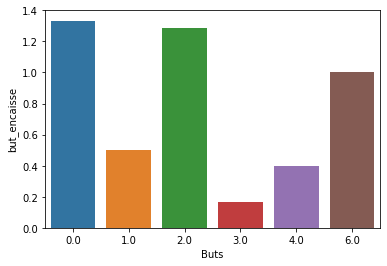

In [54]:
sns.barplot(x='Buts', y='but_encaisse', ci = None, data=df);

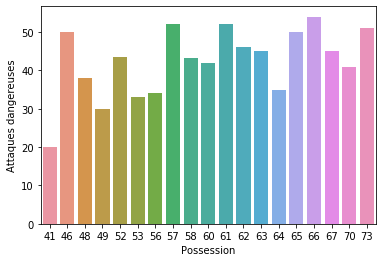

In [55]:
sns.barplot(x='Possession', y='Attaques dangereuses', ci = None, data=df)

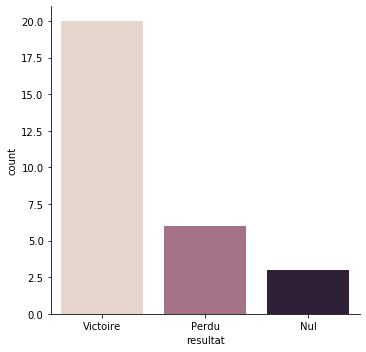

In [6]:
sns.catplot(x="resultat", kind="count", palette="ch:.1000", data=df)

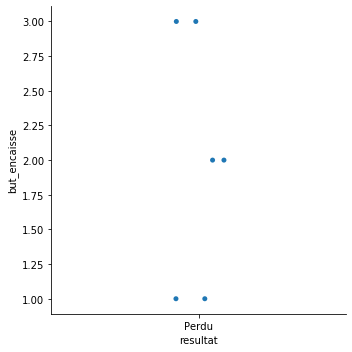

In [38]:
resultat_perdu = df[df['resultat'] == "Perdu"]


sns.catplot(x="resultat", y='but_encaisse', data=resultat_perdu)